# KPI Revenue

## Libraries

In [1]:
# importing all relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from matplotlib.dates import date2num

## Styles

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Read data

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    return trip_data

## KPI generation

### Description of KPI
The KPI "Revenue" reflects the amount of € generated in a specific time interval if we assume that all trips belong to the regular price segment (i.e. all trips are billed by 30-minute intervals, each started interval amounting to 1€).

**Important**: for sake of simplicity, we assume that all trips are billed by the 30-minute interval pricing. Thus, a part of the actual price structure, the monthly subscription, is disregarded.

#### Calculation:
- Count trip duration intervals for each trip and set the revenue to the number of 30-minute durations fitting into the trip duration, and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder > 0. 
- Examples: 
    1. If a trip was 30 mins long: trip duration / 30-minute interval = 30 / 30 = 1 --> revenue = 1 
    2. If a trip was 1 hour 12 mins long: trip duration / 30-minute interval = 72/30 = 2, remainder: 12 > 0 --> revenue = 2+1 = 3

#### Value creation for the company by the KPI
The KPI could indicate the degree to which the bike rental with the assumed price structure and current operating strategy is economically viable, for each city.
- With the help of hourly revenue, one could point out less economically viable time windows, e.g. night hours or days with extreme weather, when comparing the revenue with and relate it to one of the aforementioned aspects. If the hourly revenue is surprisingly low when it is raining, the company could adapt its strategy and reduce the fleet size for the next day when the weather forecast is strongly predicting rain for the next day, to reduce costs.
- Also, one might try to justify lowering the fleet size in locations of the city, where the generated revenue is comparably low.
- The revenue can also be used for planning purposes, since the revenue is a key aspect of financial planning.

##### Main Processing function that generates the KPI

In [4]:
def generate_revenue_per_hour_for_city(data, city, start_date, end_date):
    '''
    Processes given data and calculates the revenue per hour for a given city in a given time window

    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)
 
    def calc_revenue(x):
        '''
        Counts trip duration intervals for each trip, i.e. how much revenue each trip generated,
        by setting the revenue to the number of 30-minute durations fitting into the trip duration,
        and add 1 to the revenue if division of trip duration by 30-minute interval has a remainder
        
        Examples: 
        If a trip was 30 mins long: trip duration / 30 mins --> revenue = 1 
        If a trip was 1 hour 12 mins long: trip duration / 30 mins = 2, remainder = 12 --> revenue = 2+1 = 3
        
        :param x: a trip/row
        '''
        if (x % pd.Timedelta(minutes=30)) > pd.Timedelta(minutes=0):
            return float(math.floor(x / pd.Timedelta(minutes=30) + 1))
        else:
            return float(math.floor(x / pd.Timedelta(minutes=30)))
                              
    # apply calculation to each row
    dat["revenue_per_trip"] = dat["trip_duration"].apply(lambda x: calc_revenue(x))
    dat["revenue_per_trip_weighted"] = dat["revenue_per_trip"] / dat["fleetsize_weekly"]

    # set time window for the given data
    startDate = datetime.fromisoformat(start_date)
    endDate = datetime.fromisoformat(end_date)

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate the revenue per trip:
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    groupedByHours = dat_time_framed.groupby([times.month, times.day, times.hour, "fleetsize_weekly"])[
        "revenue_per_trip"].agg(num_of_trips_per_hour="count", total_revenue="sum")
   
    # reset index to get the groupedBy values back as columns
    groupedByHours.index.rename(["month", "day", "hour", "fleetsize_weekly"], inplace=True)
    groupedByHours.reset_index(inplace=True)
    
    # apply weight to total revenue column: divide by this week's fleetsize
    groupedByHours["total_revenue_weighted"] = groupedByHours["total_revenue"]/groupedByHours["fleetsize_weekly"]
    
    # generate string date column
    groupedByHours["date"] = "2019-" + groupedByHours["month"].astype(str) + "-" +  groupedByHours["day"].astype(str) + " " + \
                             groupedByHours["hour"].astype(str) + ":00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedByHours["datetime"] = [pd.to_datetime(d) for d in groupedByHours.date]
    groupedByHours.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedByHours["weekday"] = [dt.weekday() for dt in groupedByHours.datetime]

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedByHours["is_weekday"] = groupedByHours["weekday"] <=4
    
    return groupedByHours


##### Read in data

In [5]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

##### Set City names and time window

In [6]:
city1 = "Bremen"
city2 = "Duesseldorf"
startDate = "2019-02-01 00:00:00"
endDate = "2019-06-30 23:59:00"

##### Prepare data for Bremen: generate the KPI values and group for plotting purposes

In [7]:
## USED FOR LINE PLOTS

bremen = generate_revenue_per_hour_for_city(dataBr, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
bremen_gr_d = bremen.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate string date column 
bremen_gr_d["date"] = "2019-" + bremen_gr_d["month"].astype(str) + "-" +  bremen_gr_d["day"].astype(str)
# generate datetime column for plot labelling and remove string date column
bremen_gr_d["datetime"] = [pd.to_datetime(d) for d in bremen_gr_d.date]
bremen_gr_d.drop(["date"], axis=1, inplace=True)


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
bremen_gr_hourly = bremen.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
bremen_gr_hourly.rename(columns={'total_revenue': 'average_hourly_total_revenue', 'total_revenue_weighted': 'average_hourly_total_revenue_w'}, inplace=True)

# group by weekdays from 0-6 over the whole time window and take the average
bremen_gr_w = bremen.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
bremen_gr_w.rename(columns={'total_revenue': 'weekday_total_revenue', 'total_revenue_weighted': 'weekday_total_revenue_w'}, inplace=True)
bremen_gr_weekday = bremen_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
bremen_gr_weekday.rename(columns={'weekday_total_revenue': 'average_weekday_total_revenue', 'weekday_total_revenue_w': 'average_weekday_total_revenue_w'}, inplace=True)
# add a separate column to show if it is a working day
bremen_gr_weekday["is_working_day"] = bremen_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
bremen_gr_monthly = bremen.groupby("month")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
bremen_gr_monthly.rename(columns={'total_revenue': 'monthly_total_revenue', 'total_revenue_weighted': 'monthly_total_revenue_w'}, inplace=True)

<ipython-input-7-4d35d4f164ff>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_hourly = bremen.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
<ipython-input-7-4d35d4f164ff>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_w = bremen.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
<ipython-input-7-4d35d4f164ff>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bremen_gr_weekday = bremen_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
<ipython-input-7-4d35d4f164ff>

##### Prepare data for Düsseldorf: generate the KPI values and group for plotting purposes

In [8]:
## USED FOR LINE PLOTS

duesseldorf = generate_revenue_per_hour_for_city(dataDu, city1, startDate, endDate)
# group by specific day and sum up the revenue for each day
duesseldorf_gr_d = duesseldorf.groupby(["month","day"])["total_revenue"].agg(daily_total_revenue="sum").reset_index()
# generate string date column 
duesseldorf_gr_d["date"] = "2019-" + duesseldorf_gr_d["month"].astype(str) + "-" +  duesseldorf_gr_d["day"].astype(str)
# generate datetime column for plot labelling and remove string date column
duesseldorf_gr_d["datetime"] = [pd.to_datetime(d) for d in duesseldorf_gr_d.date]
duesseldorf_gr_d.drop(["date"], axis=1, inplace=True)


## USED FOR BAR PLOTS

# group by hours from 0-24 over the whole time window and take the average
duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
duesseldorf_gr_hourly.rename(columns={'total_revenue': 'average_hourly_total_revenue', 'total_revenue_weighted': 'average_hourly_total_revenue_w'}, inplace=True)

# group by weekdays from 0-6 over the whole time window and take the average
duesseldorf_gr_w = duesseldorf.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
duesseldorf_gr_w.rename(columns={'total_revenue': 'weekday_total_revenue', 'total_revenue_weighted': 'weekday_total_revenue_w'}, inplace=True)
duesseldorf_gr_weekday = duesseldorf_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})
duesseldorf_gr_weekday.rename(columns={'weekday_total_revenue': 'average_weekday_total_revenue', 'weekday_total_revenue_w': 'average_weekday_total_revenue_w'}, inplace=True)
# add a separate column to show if it is a working day
duesseldorf_gr_weekday["is_working_day"] = duesseldorf_gr_weekday.reset_index()["weekday"] <= 4

# group by months from 1-6 over the whole time window and sum up the revenue for each month
duesseldorf_gr_monthly = duesseldorf.groupby("month")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
duesseldorf_gr_monthly.rename(columns={'total_revenue': 'monthly_total_revenue', 'total_revenue_weighted': 'monthly_total_revenue_w'}, inplace=True)

<ipython-input-8-03a2c3d31a43>:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_hourly = duesseldorf.groupby("hour")["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"mean", "total_revenue_weighted":"mean"})
<ipython-input-8-03a2c3d31a43>:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_w = duesseldorf.groupby(["month","day", "weekday"])["total_revenue", "total_revenue_weighted"].agg({"total_revenue":"sum", "total_revenue_weighted":"sum"})
<ipython-input-8-03a2c3d31a43>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  duesseldorf_gr_weekday = duesseldorf_gr_w.groupby("weekday")["weekday_total_revenue", "weekday_total_revenue_w"].agg({"weekday_total_revenue":"mean", "weekday_total_revenue_w":"mean"})


## Plotting

### Total Revenue per Hour and per day, all data points over the selected time interval
Here, we are plotting all KPI values in a selected time frame. First, the hourly KPI values, i.e. the ungrouped KPI values are plotted.

#### Bremen, hourly
We can see the fluctuation of hourly revenue over a very long time interval (6 months containing roughly 4460 hours, so we are plotting ~4460 KPI values).

In [9]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the Bremen data set
yLimitHour = [0, bremen["total_revenue"].max()]
yLimitDay = [0, bremen_gr_d["daily_total_revenue"].max()]

[Text(0, 0, '0€'),
 Text(0, 0, '50€'),
 Text(0, 0, '100€'),
 Text(0, 0, '150€'),
 Text(0, 0, '200€'),
 Text(0, 0, '250€'),
 Text(0, 0, '300€')]

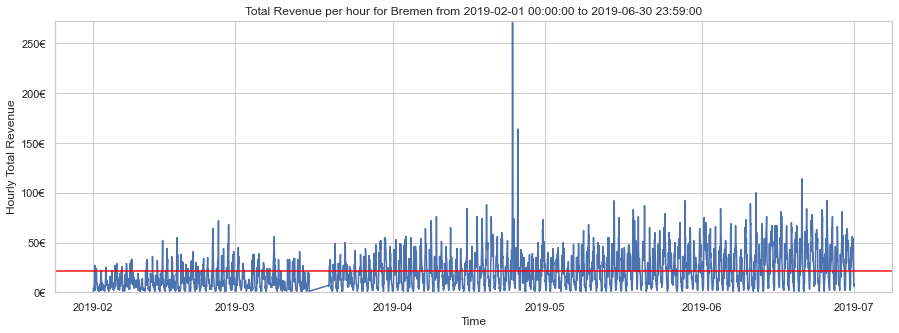

In [20]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", color='b', ci=None)
# draw line depicting the mean value
ax.axhline(y = bremen['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
# set title and axis labels
ax.set_title(f"Total Revenue per hour for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
# set axis scale limits
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in hourly KPI values is very high. The hourly generated revenue in € varies between almost 0€ up to 50€ or more from February to April. Beginning with April, the revenue per hour varies between almost 0€ and up to 100€ with some spikes above 100€ per hour (around 25.04.19). Note, that around 19.03.19 there is a lack of data points, which could be explained by an error in the nextBike API.

The mean revenue per hour is around 21€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature.

#### Bremen, daily
Here we can see the fluctuation of daily revenue over a long time interval, but with a lot less data points than the hourly plot. The variation of total revenue is better visible in this plot

[Text(0, 0, '0€'),
 Text(0, 0, '200€'),
 Text(0, 0, '400€'),
 Text(0, 0, '600€'),
 Text(0, 0, '800€'),
 Text(0, 0, '1000€'),
 Text(0, 0, '1200€')]

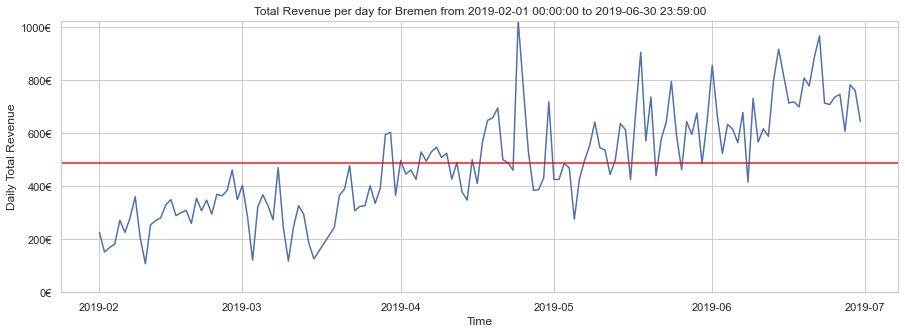

In [19]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

g = sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", color='b', ci=None)
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in daily KPI values is also high. The daily generated revenue in € ranges from ~100€ up to ~1000€.

The mean revenue per hour is around 488€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature as well.

#### Düsseldorf, hourly
We can see the fluctuation of hourly revenue over a very long time interval (6 months containing roughly 4460 hours, so we are plotting ~4460 KPI values).

[Text(0, 0, '0€'),
 Text(0, 0, '50€'),
 Text(0, 0, '100€'),
 Text(0, 0, '150€'),
 Text(0, 0, '200€'),
 Text(0, 0, '250€'),
 Text(0, 0, '300€')]

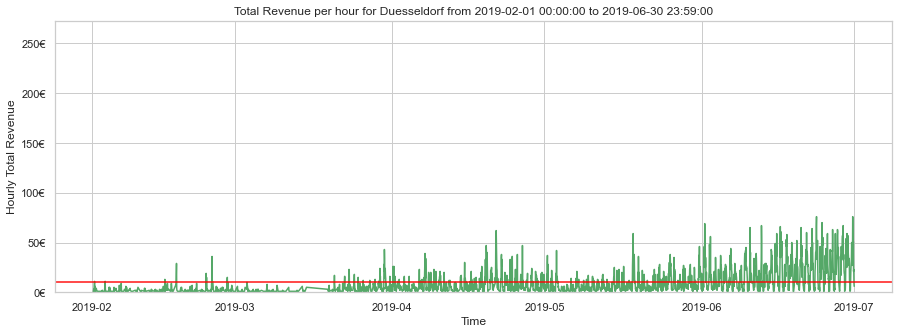

In [12]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
g = sns.lineplot(ax=ax, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", color='g', ci=None)
ax.axhline(y = duesseldorf['total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per hour for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in hourly KPI values is lower than in Bremen. The hourly generated revenue in € varies between almost 0€ up to 75€. Note, that around 19.03.19 there is also a lack of data points, which could be explained by an error in the nextBike API.

The mean revenue per hour is around 11€, which is depicted by the red line.

Altogether, there is a positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature.

#### Düsseldorf, Daily
Here we can see the fluctuation of daily revenue over a long time interval, but with a lot less data points than the hourly plot. The variation of total revenue is better visible in this plot

[Text(0, 0, '0€'),
 Text(0, 0, '200€'),
 Text(0, 0, '400€'),
 Text(0, 0, '600€'),
 Text(0, 0, '800€'),
 Text(0, 0, '1000€'),
 Text(0, 0, '1200€')]

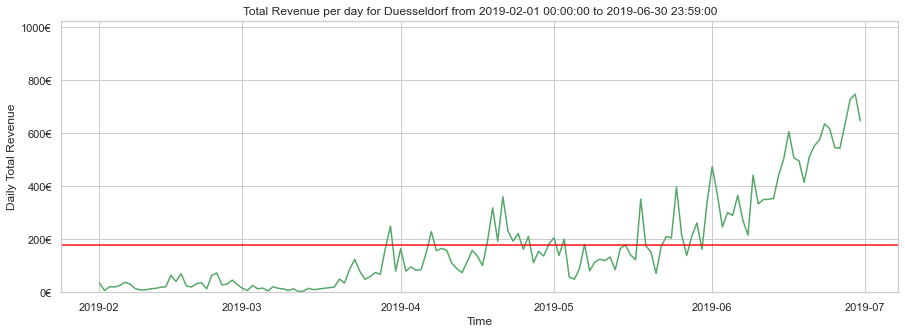

In [13]:
# create figure and axes
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# generate plots
g = sns.lineplot(ax=ax, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", color='g', ci=None)
ax.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='red', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay) # set y axis limit to maximum of daily values from bremen

# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

The fluctuation in daily KPI values over the whole time window is higher than in Bremen. The daily generated revenue in € ranges from ~0€ up to ~780€.

The mean revenue per hour is around 180€, which is depicted by the red line.

Altogether, there is a very strong positive trend of generated € per hour from february until end of june, which can be easily explained by higher number of trips and longer trips in time periods with higher temperature as well. But also one should note, that the trend seems disproportionately stronger than the plot of Bremen suggests, which asks for forther explanation

#### Both Cities, hourly
Here we can see the fluctuation of hourly revenue for both cities in comparison

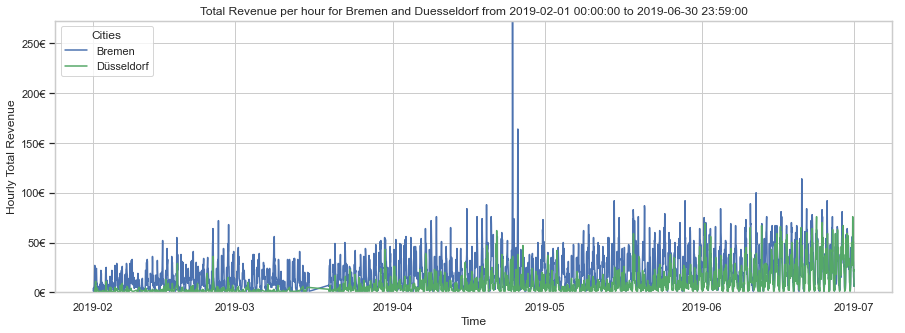

In [14]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen.reset_index(), x="datetime", y="total_revenue", color='b', ci=None, label="Bremen")
ax.set_title(f"Total Revenue per hour for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Hourly Total Revenue")
ax.set_xlabel("Time")
ax.legend().set_visible(False) # removes a legend that would show up on the right side
ax.set_ylim(yLimitHour)
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)

# generate twin axis to show the values of duesseldorf on the same figure
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf.reset_index(), x="datetime", y="total_revenue", color='g', ci=None, label="Düsseldorf")
ax2.set_ylim(yLimitHour) 
ax2.yaxis.set_visible(False) # make second y-axis invisible

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

##### Note: Both data sets show an irregularity around 2019-03-20, seems to be some kind of error in the provided data

#### Both Cities, daily
Here we can see the fluctuation of daily revenue for both cities in comparison

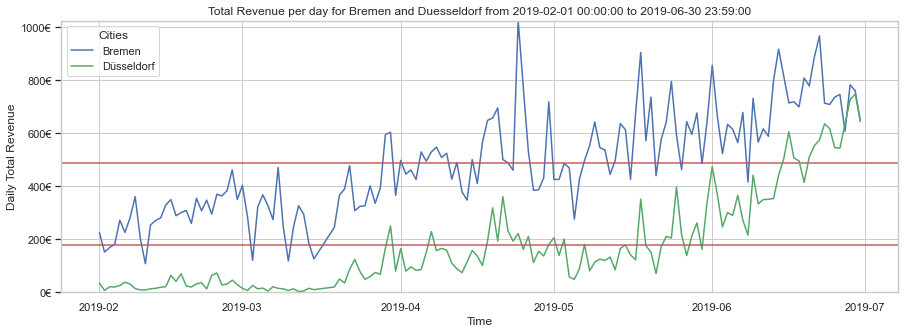

In [15]:
# generate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

# generate line plot
g = sns.lineplot(ax=ax, data=bremen_gr_d, x="datetime", y="daily_total_revenue", color='b', ci=None, label="Bremen")
# draw line depicting the mean value
ax.axhline(y = bremen_gr_d['daily_total_revenue'].mean(), color='r', linewidth=2, alpha=.7)
ax.set_title(f"Total Revenue per day for {city1} and {city2} from {startDate} to {endDate}")
ax.set_ylabel("Daily Total Revenue")
ax.set_xlabel("Time")
ax.set_ylim(yLimitDay)
ax.legend().set_visible(False) # removes a legend that would show up on the right side
# set yAxis € labels
yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
g.set_yticklabels(yTickLabels)


# generate twin axis
ax2 = ax.twinx()

# generate second line plot
sns.lineplot(ax=ax2, data=duesseldorf_gr_d, x="datetime", y="daily_total_revenue", color='g', ci=None, label="Düsseldorf")
# draw line depicting the mean value
ax2.axhline(y = duesseldorf_gr_d['daily_total_revenue'].mean(), color='r', linewidth=2, alpha=.7)
ax2.set_ylim(yLimitDay)
ax2.yaxis.set_visible(False)

# set handles and labels for legend manually
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels, loc="upper left", title="Cities")

Here we can see that the generated revenue in Düsseldorf reaches the same level as the revenue generated in Bremen in late June.

### Total Revenue per Hour, averaged over the selected time interval and grouped over hours 0-24
Here, we are plotting the KPI values in the selected time frame grouped by Hours 0-24, grouped by weekdays and the totals for each month.

The first variant of plots is plotting the grouped absolute values, the second variant of plots is plotting the ratio of value/fleet size, grouped.

In [16]:
# setting limits for y-axis of the following plots by taking the minimum and maximum values of the grouped data for bremen
yLimit_gr_hourly = [0, bremen_gr_hourly["average_hourly_total_revenue"].max()]
yLimit_gr_weekday = [0, bremen_gr_weekday["average_weekday_total_revenue"].max()]
yLimit_gr_monthly = [0, bremen_gr_monthly["monthly_total_revenue"].max()]

yLimit_gr_hourly_w = [0, bremen_gr_hourly["average_hourly_total_revenue_w"].max()]
yLimit_gr_weekday_w = [0, bremen_gr_weekday["average_weekday_total_revenue_w"].max()]
yLimit_gr_monthly_w = [0, bremen_gr_monthly["monthly_total_revenue_w"].max()]

#### Bremen

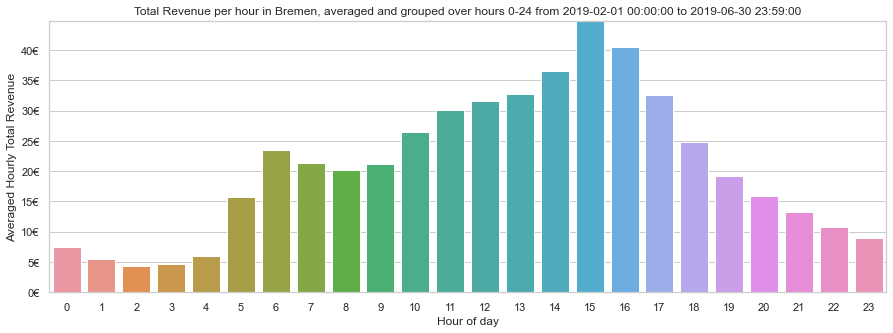

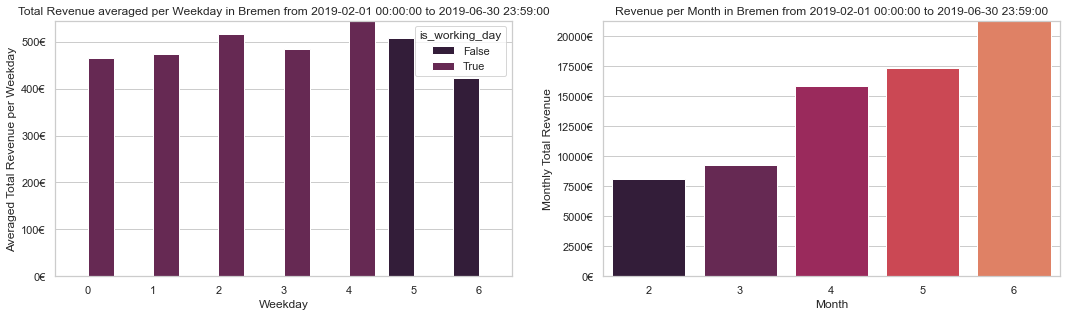

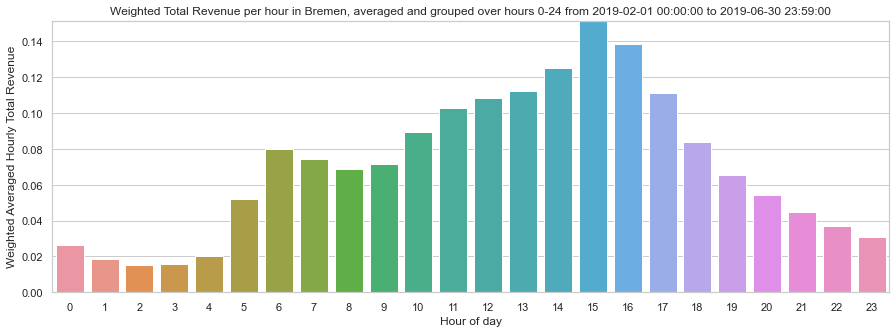

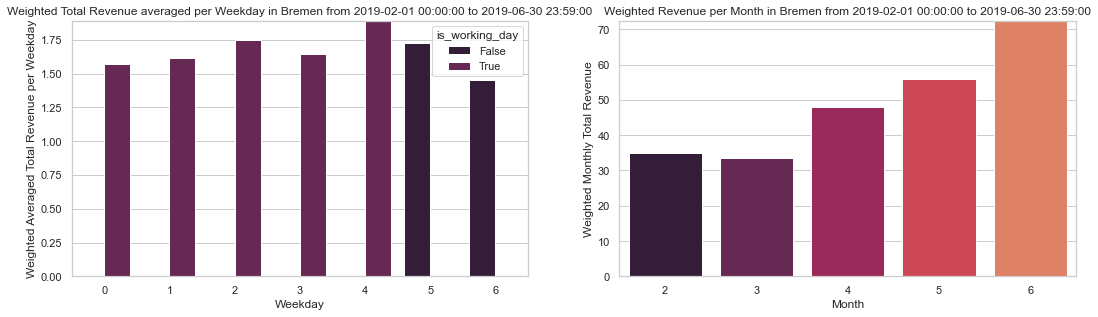

In [17]:
def tickLabels(g, weighted = False):
    # set yAxis € labels
    if not weighted:
        yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
        g.set_yticklabels(yTickLabels)

def createBarPlotsBremen(weighted=False):
    # create figure and axes for values grouped by hours 0-24
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    # provide different columns and labelling depending on the 'weighted' param
    if not weighted:
        yColumns = ["average_hourly_total_revenue", "average_weekday_total_revenue", "monthly_total_revenue"]
    else: 
        yColumns = ["average_hourly_total_revenue_w", "average_weekday_total_revenue_w", "monthly_total_revenue_w"]
    ifWeighted = "Weighted " if weighted else ""
    
    g = sns.barplot(ax=ax, data=bremen_gr_hourly.reset_index(), x="hour", y=yColumns[0], ci=None)
    ax.set_title(f"{ifWeighted}Total Revenue per hour in {city1}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
    ax.set_ylabel(f"{ifWeighted}Averaged Hourly Total Revenue")
    ax.set_xlabel("Hour of day")
    ax.set_ylim(yLimit_gr_hourly_w if weighted else yLimit_gr_hourly)
    # set yAxis € labels
    tickLabels(g, weighted)

    # create figure and axes for values grouped by weekdays and for monthly total values
    fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    g2 = sns.barplot(ax=ax2, data=bremen_gr_weekday.reset_index(), x="weekday", y=yColumns[1], hue="is_working_day", ci=None)
    ax2.set_title(f"{ifWeighted}Total Revenue averaged per Weekday in {city1} from {startDate} to {endDate}")
    ax2.set_ylabel(f"{ifWeighted}Averaged Total Revenue per Weekday")
    ax2.set_xlabel("Weekday")
    ax2.set_ylim(yLimit_gr_weekday_w if weighted else yLimit_gr_weekday)
    # set yAxis € labels
    tickLabels(g2, weighted)

    g3 = sns.barplot(ax=ax3, data=bremen_gr_monthly.reset_index(), x="month", y=yColumns[2], ci=None)
    ax3.set_title(f"{ifWeighted}Revenue per Month in {city1} from {startDate} to {endDate}")
    ax3.set_ylabel(f"{ifWeighted}Monthly Total Revenue")
    ax3.set_xlabel("Month")
    ax3.set_ylim(yLimit_gr_monthly_w if weighted else yLimit_gr_monthly)
    # set yAxis € labels
    tickLabels(g3, weighted)

    fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25) # adjust spacing for overlapping plot titles
    
createBarPlotsBremen()
createBarPlotsBremen(weighted=True)

#### Düsseldorf

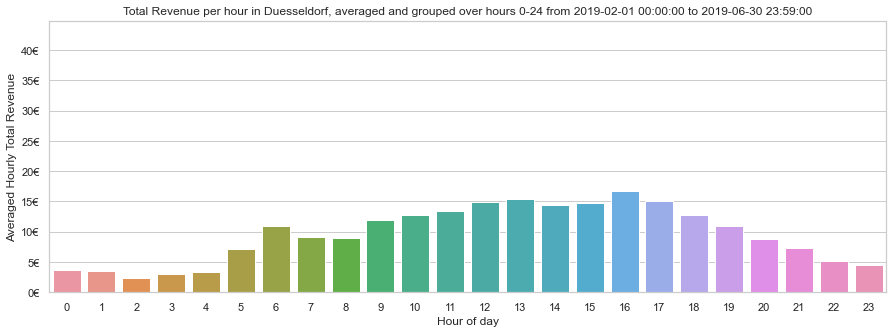

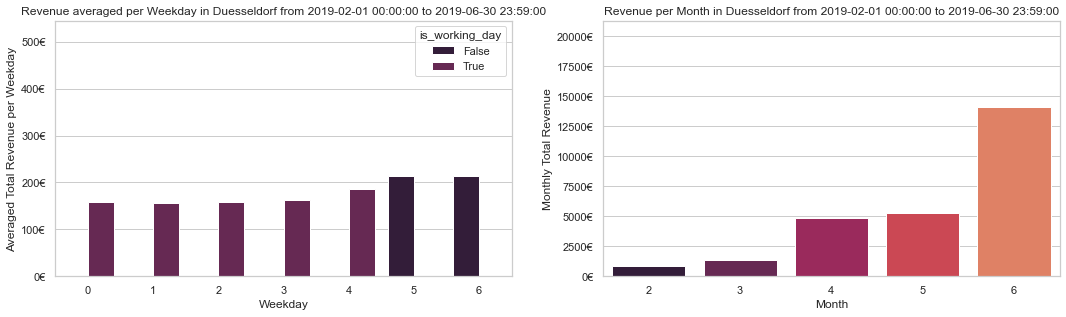

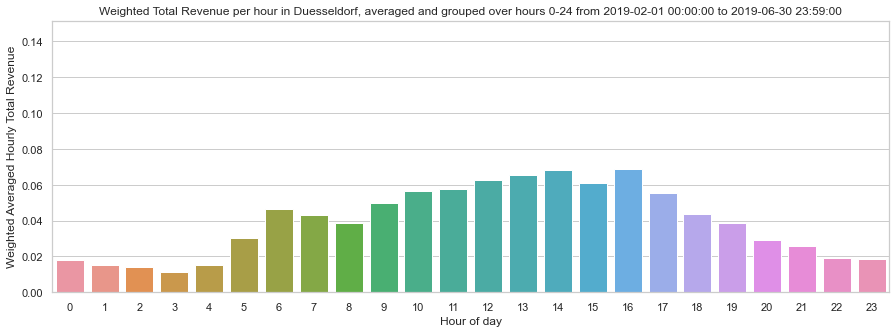

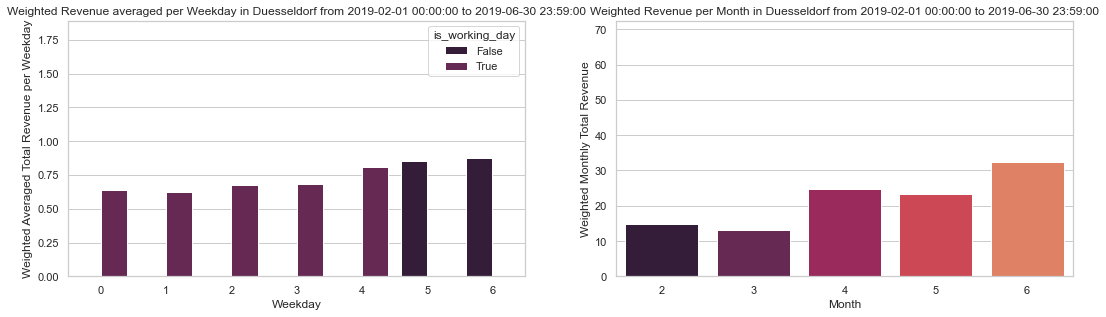

In [18]:
def tickLabels(g, weighted = False):
    # set yAxis € labels
    if not weighted:
        yTickLabels = [str(int(y))+'€' for y in g.get_yticks()]
        g.set_yticklabels(yTickLabels)

def createBarPlotsDuesseldorf(weighted=False):
    # create figure and axes for values grouped by hours 0-24
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    # provide different columns and labelling depending on the 'weighted' param
    if not weighted:
        yColumns = ["average_hourly_total_revenue", "average_weekday_total_revenue", "monthly_total_revenue"]
    else: 
        yColumns = ["average_hourly_total_revenue_w", "average_weekday_total_revenue_w", "monthly_total_revenue_w"]
    ifWeighted = "Weighted " if weighted else ""
    
    g = sns.barplot(ax=ax, data=duesseldorf_gr_hourly.reset_index(), x="hour", y=yColumns[0], ci=None)
    ax.set_title(f"{ifWeighted}Total Revenue per hour in {city2}, averaged and grouped over hours 0-24 from {startDate} to {endDate}")
    ax.set_ylabel(f"{ifWeighted}Averaged Hourly Total Revenue")
    ax.set_xlabel("Hour of day")
    ax.set_ylim(yLimit_gr_hourly_w if weighted else yLimit_gr_hourly)
    tickLabels(g, weighted)
    
    # create figure and axes for values grouped by weekdays and for monthly total values
    fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    g2 = sns.barplot(ax=ax2, data=duesseldorf_gr_weekday.reset_index(), x="weekday", y=yColumns[1], hue="is_working_day", ci=None)
    ax2.set_title(f"{ifWeighted}Revenue averaged per Weekday in {city2} from {startDate} to {endDate}")
    ax2.set_ylabel(f"{ifWeighted}Averaged Total Revenue per Weekday")
    ax2.set_xlabel("Weekday")
    ax2.set_ylim(yLimit_gr_weekday_w if weighted else yLimit_gr_weekday)
    tickLabels(g2, weighted)
    
    g3 = sns.barplot(ax=ax3, data=duesseldorf_gr_monthly.reset_index(), x="month", y=yColumns[2], ci=None)
    ax3.set_title(f"{ifWeighted}Revenue per Month in {city2} from {startDate} to {endDate}")
    ax3.set_ylabel(f"{ifWeighted}Monthly Total Revenue")
    ax3.set_xlabel("Month")
    ax3.set_ylim(yLimit_gr_monthly_w if weighted else yLimit_gr_monthly)
    tickLabels(g3, weighted)
    
    fig2.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.25) # adjust spacing for overlapping plot titles
    
createBarPlotsDuesseldorf()
createBarPlotsDuesseldorf(weighted=True)